In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [9]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_test_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [11]:
# Load datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

In [12]:
# Define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True) 
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64) 
testloader = torch.utils.data.DataLoader(test_data, batch_size=64) 

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [14]:
# Load Densenet-121 pre-trained network from ImageNet and see architecture
model = models.densenet121(pretrained=True)
model

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [15]:
# Freeze Parameters, so they are not manipulted durcin backward pass
for param in model.parameters():
    param.requieres_grad=False

# output layer of pre-trained model does not match our output of 102 flowers --> adjust classifier
# use dropout to avoid overfitting

network = nn.Sequential(OrderedDict([('fc1', nn.Linear(1024, 512)),
                                     ('relu1', nn.ReLU()),
                                     ('drop1', nn.Dropout(p=0.2)),
                                     ('fc2', nn.Linear(512, 102)),
                                     ('soft2', nn.LogSoftmax(dim=1))]))

# set the defined neural network to be the new classifier for the model and set methods for the error function and optimizer
model.classifier = network

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [16]:
# Use GPU if it is available, otherwise local CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
epochs = 5
steps = 0 # number of train steps
train_loss = 0
print_every = 31
train_losses, valid_losses = [], []

In [18]:
from workspace_utils import active_session
model.to(device)
with active_session():
    # Train model and calculate and print accuracy every 10 steps of process
    for epoch in range(epochs):
        # TRAIN
        for images, labels in trainloader:
            steps += 1
            # Move input and label tensors to the default device (GPU, if it is available)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # reset gradients to 0 (they are added otherwise)
            output = model.forward(images) # run batch of images through model and get predictions
            loss = criterion(output, labels) # calculate error by comparing predictions to labels (true values)
            loss.backward() # perform backward pass
            optimizer.step() # adjust weights

            train_loss += loss.item()
            
            # VALIDATE
            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval() # switch to evaluation mode --> dropout is deactivated
                with torch.no_grad(): # turn off tracking of gradients
                    for images, labels in validloader:
                        images, labels = images.to(device), labels.to(device) # move images/labels of validation set to GPU
                        
                        # validate model by passing validation images through model and 
                        # comparing model prediction with true label
                        output = model.forward(images)
                        batch_loss = criterion(output, labels)
                        valid_loss += batch_loss.item()
                        
                        # Calculate accuracy for statistics
                        ps = torch.exp(output)
                        top_p, top_class = ps.topk(1, dim=1) # get prediction with highest probability for each image
                        # create equals tensor with 1 (prediction=label) and 0 (else)
                        equals = top_class == labels.view(*top_class.shape)
                        # calculate accuracy by taking mean of 1's and 0's
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item() 
                      
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {train_loss/print_every:.3f}.. "
                      f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                      f"Validation accuracy: {accuracy/len(validloader):.3f}")
                
                # save value for training and validaton loss for graphical overview
                train_losses.append(train_loss/print_every) 
                valid_losses.append(valid_loss/len(validloader))
                
                train_loss = 0
                model.train()      

Epoch 1/5.. Train loss: 4.049.. Validation loss: 3.047.. Validation accuracy: 0.375
Epoch 1/5.. Train loss: 2.622.. Validation loss: 1.656.. Validation accuracy: 0.618
Epoch 1/5.. Train loss: 1.765.. Validation loss: 0.987.. Validation accuracy: 0.760
Epoch 2/5.. Train loss: 1.405.. Validation loss: 0.814.. Validation accuracy: 0.776
Epoch 2/5.. Train loss: 1.185.. Validation loss: 0.649.. Validation accuracy: 0.836
Epoch 2/5.. Train loss: 1.041.. Validation loss: 0.525.. Validation accuracy: 0.865
Epoch 3/5.. Train loss: 0.976.. Validation loss: 0.557.. Validation accuracy: 0.862
Epoch 3/5.. Train loss: 0.848.. Validation loss: 0.510.. Validation accuracy: 0.854
Epoch 3/5.. Train loss: 0.891.. Validation loss: 0.512.. Validation accuracy: 0.868
Epoch 4/5.. Train loss: 0.858.. Validation loss: 0.417.. Validation accuracy: 0.891
Epoch 4/5.. Train loss: 0.795.. Validation loss: 0.389.. Validation accuracy: 0.898
Epoch 4/5.. Train loss: 0.791.. Validation loss: 0.392.. Validation accuracy

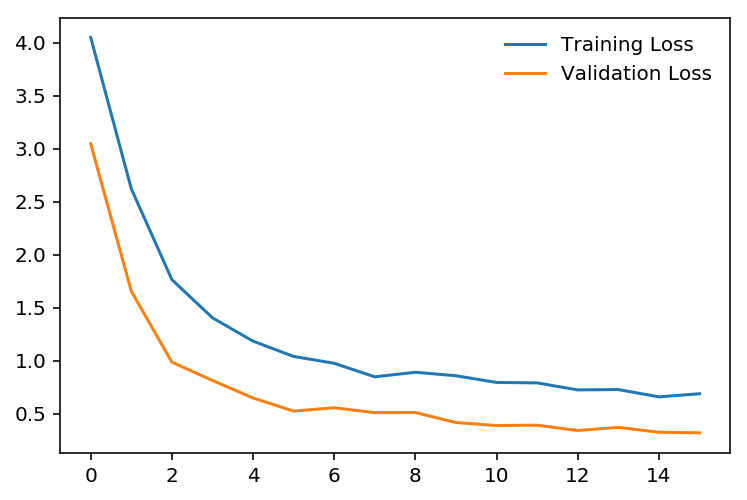

In [19]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [20]:
test_loss=0
test_accuracy=0

model.eval() # switch to evaluation mode --> dropout is deactivated

with torch.no_grad(): # turn off tracking of gradients
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device) # move images/labels of test set to GPU
        output = model.forward(images)
        batch_loss = criterion(output, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item() 

print(f"Validation accuracy: {accuracy/len(validloader):.3f}")
print(f"Test accuracy: {test_accuracy/len(testloader):.3f}")
      

Validation accuracy: 0.920
Test accuracy: 0.889


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [21]:
# Create and save checkpoint
model.class_to_idx = train_data.class_to_idx
checkpoint = {'arch': 'densenet121',
              'classifier': model.classifier,
              'classifier_state_dict': model.classifier.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'class_to_idx': model.class_to_idx,
              'epochs': epochs,}
torch.save(checkpoint,'classifier_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    if checkpoint['arch'] == 'densenet121':
        model = models.densenet121(pretrained=True) # Use pre-trained densenet121 model as basis
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = checkpoint['classifier'] # use previously defined classifier architecture
    model.classifier.load_state_dict(checkpoint['classifier_state_dict']) #set weigths/bias resulting from previous training
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model 

In [23]:
model_load = load_checkpoint('classifier_checkpoint.pth')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [24]:
test_loss=0
test_accuracy=0

model_load.to(device)
model_load.eval() # switch to evaluation mode --> dropout is deactivated

with torch.no_grad(): # turn off tracking of gradients
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device) # move images/labels of test set to GPU
        output = model_load.forward(images)
        batch_loss = criterion(output, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item() 

print(f"Validation accuracy: {accuracy/len(validloader):.3f}")
print(f"Test accuracy: {test_accuracy/len(testloader):.3f}")

Validation accuracy: 0.920
Test accuracy: 0.473


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [25]:
def process_image(image):
    '''Modifies the input image and returns a numpy array'''
    # RESIZE image with 256 pixels on shortest side
    # CROP image 224x224 pixel around center
    preprocessing = transforms.Compose([
                        transforms.Resize(256), 
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])
    
    pil_img = Image.open(image)
    img_tensor = preprocessing(pil_img)
    
    # Normalize Image
    np_image = np.array(img_tensor)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np.transpose(np_image, (1, 2, 0)) - mean)/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [26]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

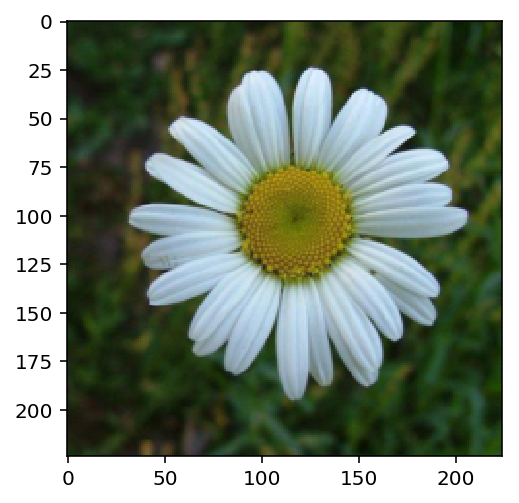

In [27]:
imshow(process_image('flowers/valid/49/image_06235.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [28]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Model
    model.eval() # switch to evaluation mode --> dropout is deactivated
    
    # Image
    np_image = process_image(image_path) # numpy array image
    tensor_image =  torch.from_numpy(np_image).type(torch.FloatTensor).to(device) # converty np image to tensor
    tensor_image = tensor_image.unsqueeze(0)
    
    with torch.no_grad(): # turn off tracking of gradients
        prediction = model.forward(tensor_image)
        
        # Get top-5 probabilities and classes
        ps = torch.exp(prediction)
        top_ps, top_idx = ps.topk(topk, dim=1)
        
        # Convert tensors to lists
        top_ps = top_ps.tolist()[0]
        top_idx = top_idx.tolist()[0]        
        
        # Get classes from indices
        idx_to_class = {model.class_to_idx[k] : k for k in model.class_to_idx} # Create inverted dictionary (index --> class)
        top_classes = []
        for i in top_idx:
            top_classes.append(idx_to_class[i])

    return top_ps, top_classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [29]:
model.to(device)

image_path = 'flowers/valid/49/image_06235.jpg'
top_ps, top_classes = predict(image_path, model, 5) # get top5 predictions for image

# convert classes to flower names
top_labels = []
for flower_class in top_classes:
    top_labels.append(cat_to_name[flower_class])

print(top_ps)
print(top_labels)

[0.9663268327713013, 0.0060644326731562614, 0.006014250218868256, 0.005881570279598236, 0.004912008065730333]
['oxeye daisy', 'black-eyed susan', 'sunflower', 'tree poppy', 'osteospermum']


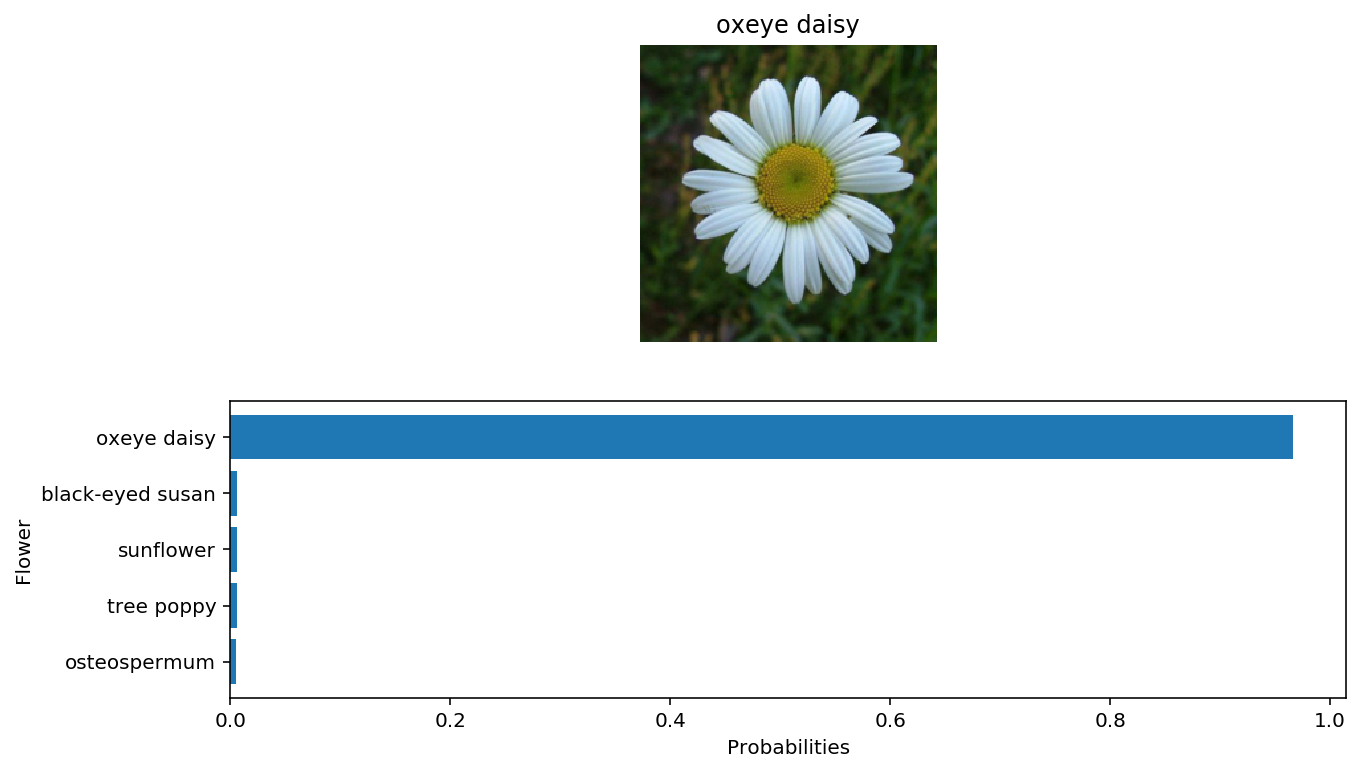

In [30]:
plt.figure(figsize=[10,6])

# Picture of Flower
plt.subplot(2,1,1)
image = process_image(image_path)
ax1 = imshow(image, ax=plt)
ax1.title(top_labels[0])
ax1.axis('off')

# Bar Chart for Predictions
plt.subplot(2,1,2)
y_pos = np.arange(len(top_labels))
plt.barh(y_pos, list(reversed(top_ps)), align='center')
plt.yticks(y_pos, list(reversed(top_labels)))
plt.ylabel('Flower')
plt.xlabel('Probabilities')

plt.show()